## Group Name: Yolo

### Group Members: 

#### Dillon Quan
#### Mikio Tada
#### Shrikar Thodla

In [1]:
# import the necessary libraries
from rfpimp import *
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from tqdm import tqdm

import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

## Load Data

In [2]:
# reading in the file into pandas dataframe
df = pd.read_csv('train_reduce.csv')

# separating the target variable and the predictor variables
df_X = df.drop(columns=['hotel_cluster'])
df_y = df['hotel_cluster']

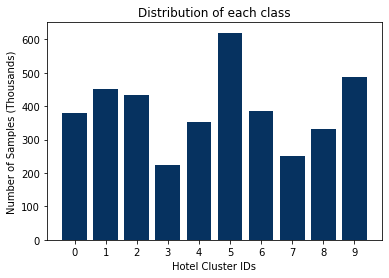

In [3]:
# Checking the distributions of each target label
clusters = []
for idx in range(0, 10):
    clusters.append(df_y.loc[(df_y == idx)].shape[0])

# bar graph for the number of samples per class
plt.bar([idx for idx in range(10)], [cluster/1000 for cluster in clusters], color='#063260')
plt.xticks(np.arange(10))
plt.title('Distribution of each class')
plt.xlabel('Hotel Cluster IDs')
plt.ylabel('Number of Samples (Thousands)')
plt.show()

In [4]:
# using stratified shuffle split to get 25% of the filter data while maintaing the distribution (~ 1mil samples)
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.25, random_state=0)
for train_idx, test_idx in sss.split(df_X, df_y):
    X_train, X_test = df_X.iloc[train_idx], df_X.iloc[test_idx]
    y_train, y_test = df_y.iloc[train_idx], df_y.iloc[test_idx]

## Datetime Feature Engineering

In [5]:
def datetime_eng(dataframe):
    """Perform the proper datetime feature engineering on the appropriate features."""
    
    # feature engineering into datetime
    dataframe['date_time'] = pd.to_datetime(dataframe['date_time'], yearfirst=True)
    dataframe['srch_ci'] = pd.to_datetime(dataframe['srch_ci'], yearfirst=True, errors='coerce')
    dataframe['srch_co'] = pd.to_datetime(dataframe['srch_co'], yearfirst=True, errors='coerce')

    # timedelta for days in advance feature
    dataframe['advance'] = dataframe['srch_ci'] - dataframe['date_time']
    dataframe['advance'] = dataframe.advance.dt.days

    # duration of stays
    dataframe['duration'] = dataframe['srch_co'] - dataframe['srch_ci']
    dataframe['duration'] = dataframe.duration.dt.days
    
    return dataframe

In [6]:
def drop_col(dataframe):
    """Drop the unecessary columns."""
    dataframe = dataframe.drop(columns=['user_id', 'site_name',
                                        'user_location_region',
                                        'date_time', 'srch_ci',
                                        'srch_co'])
    return dataframe

In [7]:
# reset the index after randomly sampling a subset
sample_x = X_train.reset_index(drop=True)
sample_y = y_train.reset_index(drop=True)

# calling datetime and drop column
sample_x = datetime_eng(sample_x)
sample_x = drop_col(sample_x)

## Pipeline

In [8]:
# Train test split the data
xtrain, xtest, ytrain, ytest = train_test_split(sample_x, sample_y, test_size=.2, random_state=42)
xtrain.shape, xtest.shape

((784124, 19), (196031, 19))

In [9]:
# Building the pipeline
def make_pipeline():
    """This function here makes the pipeline but does not include the clf to prevent data leakage."""
    
    date_features = ['advance', 'duration']
    date_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))])

    distance = ['orig_destination_distance']
    distance_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    preprocessor = ColumnTransformer(transformers=[('date', date_transformer, date_features),
                                                   ('dist', distance_transformer, distance)],
                                                   remainder='passthrough')
    
    return preprocessor

In [10]:
def make_random_cv(cv, n_iter, n_estimators):
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate RandomizedSearchCV
    """
    
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                random_state=42, 
                                max_depth=10, 
                                oob_score=True,
                                n_jobs=4)
    
    params_grid = {'max_features': [2, 5, 10, 16],
                  'min_samples_leaf': [100, 500, 1000, 2000]}
    
    clf_random_cv = RandomizedSearchCV(estimator=rf, scoring='precision_weighted',
                                       param_distributions=params_grid,
                                       n_iter=n_iter, cv=cv)
                                         
    return clf_random_cv

In [11]:
# make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(xtrain)
trans_xtest = pipeline.transform(xtest)
trans_xtrain.shape  # sanity check of datashape

(784124, 19)

## Baseline Models with different ML Algorithms
Evaluated on accuracy and precision but focusing on maximizing precision to make sure expedia can predict customer behavior as much as possible.

### Random Forest

In [12]:
# creating the RandomizedSearchCV and using the best estimator
randomize_clf = make_random_cv(3, 5, 2)  # 3-fold, 5 iterations
randomize_clf.fit(trans_xtrain, ytrain)
best_rf = randomize_clf.best_estimator_  # returning the best estimator
randomize_clf.best_params_

{'min_samples_leaf': 100, 'max_features': 10}

In [13]:
# fitting the best estimator and getting the training scores
best_rf.fit(trans_xtrain, ytrain)
print(f"Out-of-Bag Accuracy: {best_rf.oob_score_}")
print(f"Train Accuracy: {accuracy_score(ytrain, best_rf.predict(trans_xtrain))}")
print(f"Test Accuracy: {accuracy_score(ytest, best_rf.predict(trans_xtest))}")

Out-of-Bag Accuracy: 0.348910376420056
Train Accuracy: 0.5385946610485076
Test Accuracy: 0.5371038254153679


In [14]:
# getting the test precision scores
print(f"Training weighted-precision-score: {precision_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing weighted-precision-score: {precision_score(ytest, best_rf.predict(trans_xtest), average='weighted')}")

Training weighted-precision-score: 0.5368408627525797
Testing weighted-precision-score: 0.5350702111044754


### Decision Tree

In [15]:
dt = DecisionTreeClassifier()
dt.fit(trans_xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [16]:
# Accuracy scores
print(f"Training Accuracy Score: {accuracy_score(ytrain, dt.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, dt.predict(trans_xtest))}")

Training Accuracy Score: 0.9953986869423713
Testing Accuracy Score: 0.586335834638399


In [17]:
# Training Classification Report
print(classification_report(ytrain, dt.predict(trans_xtrain)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75918
           1       1.00      1.00      1.00     90583
           2       0.99      1.00      0.99     86805
           3       0.99      1.00      1.00     45062
           4       1.00      1.00      1.00     70263
           5       0.99      0.99      0.99    124021
           6       1.00      0.99      1.00     76828
           7       1.00      0.99      1.00     50547
           8       1.00      0.99      0.99     66269
           9       1.00      0.99      0.99     97828

    accuracy                           1.00    784124
   macro avg       1.00      1.00      1.00    784124
weighted avg       1.00      1.00      1.00    784124



In [18]:
# Testing Classification Report
print(classification_report(ytest, dt.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72     19055
           1       0.99      0.99      0.99     22590
           2       0.50      0.51      0.50     21825
           3       0.48      0.48      0.48     11251
           4       0.54      0.54      0.54     17699
           5       0.47      0.47      0.47     31027
           6       0.46      0.46      0.46     19270
           7       0.55      0.55      0.55     12565
           8       0.65      0.64      0.65     16495
           9       0.49      0.49      0.49     24254

    accuracy                           0.59    196031
   macro avg       0.59      0.58      0.59    196031
weighted avg       0.59      0.59      0.59    196031



### Logistic Regression

In [19]:
def make_pipelines_lr():
    """Create pipeline for simple logistic regression."""
    pipe_log = Pipeline([('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs' ))])
    pipelines = [pipe_log]
    return pipelines

In [20]:
pipelines_lr = make_pipelines_lr()

In [21]:
#precision score
def sort_models_precision(pipelines, X_data, y_data, metric=accuracy_score, average="weighted"):
    """This function calculates the precision score."""
    score = []
    
    for pipe in pipelines:
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        pipe.fit(X_data, y_data)
        y_train_pred = pipe.predict(X_data)
        accuracy = round(metric(y_data, y_train_pred, average=average), 2)
        score.append((name, accuracy))

    for model in score:
        print(f"test socre with {model[0]} is {model[1]}")
        
    return score

In [22]:
sort_models_precision(pipelines_lr, trans_xtest, ytest, metric=precision_score)

test socre with LogisticRegression is 0.12


[('LogisticRegression', 0.12)]

In [23]:
#accuracy score
def sort_models_accuracy(pipelines, X_data, y_data, metric=accuracy_score):
    """This function computes the accuracy of the model."""
    score = []
    
    for pipe in pipelines:
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        pipe.fit(X_data, y_data)
        y_train_pred = pipe.predict(X_data)
        accuracy = round(metric(y_data, y_train_pred), 2)
        score.append((name, accuracy))

    for model in score:
        print(f"test socre with {model[0]} is {model[1]}")
        
    return score

In [24]:
sort_models_accuracy(pipelines_lr, trans_xtest, ytest, metric=accuracy_score)

test socre with LogisticRegression is 0.19


[('LogisticRegression', 0.19)]

### KNN

In [25]:
def make_pipelines_knn():
    """This function created a pipeline for simple knn model."""
    pipe_knn = Pipeline([('scl', StandardScaler()),('clf', KNeighborsClassifier())])
    pipelines = [pipe_knn]
    return pipelines

In [26]:
pipelines_knn = make_pipelines_knn()

In [27]:
sort_models_precision(pipelines_knn, trans_xtest, ytest, metric=precision_score)

test socre with KNeighborsClassifier is 0.53


[('KNeighborsClassifier', 0.53)]

In [28]:
sort_models_accuracy(pipelines_knn, trans_xtest, ytest, metric=accuracy_score)

test socre with KNeighborsClassifier is 0.52


[('KNeighborsClassifier', 0.52)]

## Hyperparameter Tuning 

### Random Forest (1 million samples)

In [29]:
# creating the RandomizedSearchCV and using the best estimator
best_params = []
oob_scores = []
precision_train = []
precision_test = []
train_acc = []
test_acc = []

for n in tqdm([1, 5, 10, 20, 50, 100]):
    randomize_clf = make_random_cv(cv=3, n_iter=5, n_estimators=n)  # 3-fold, 5 iterations
    randomize_clf.fit(trans_xtrain, ytrain)
    best_rf = randomize_clf.best_estimator_  # returning the best estimator
    
    # fitting the best estimator and getting the training scores
    best_rf.fit(trans_xtrain, ytrain)
    train_acc.append(accuracy_score(ytrain, best_rf.predict(trans_xtrain)))  # train_acc
    test_acc.append(accuracy_score(ytest, best_rf.predict(trans_xtest)))  # test_acc
    oob_scores.append(best_rf.oob_score_)  # list of oob scores
    best_params.append(randomize_clf.best_params_)  # creating a list of best params
    precision_train.append(precision_score(ytrain, best_rf.predict(trans_xtrain), average='weighted'))
    precision_test.append(precision_score(ytest, best_rf.predict(trans_xtest), average='weighted'))

100%|██████████| 6/6 [1:20:30<00:00, 805.16s/it] 


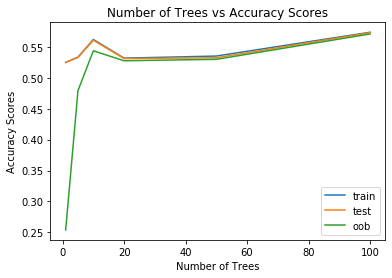

In [30]:
# Accuracy Plots
n_trees = [1, 5, 10, 20, 50, 100]
plt.plot(n_trees, train_acc, label='train')
plt.plot(n_trees, test_acc, label='test')
plt.plot(n_trees, oob_scores, label='oob')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy Scores')
plt.title('Number of Trees vs Accuracy Scores')
plt.legend(loc='lower right')
plt.show()

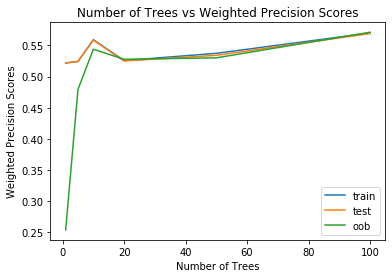

In [31]:
# Precision plots
plt.plot(n_trees, precision_train, label='train')
plt.plot(n_trees, precision_test, label='test')
plt.plot(n_trees, oob_scores, label='oob')
plt.xlabel('Number of Trees')
plt.ylabel('Weighted Precision Scores')
plt.title('Number of Trees vs Weighted Precision Scores')
plt.legend(loc='lower right')
plt.show()

In [32]:
# best set of hyperparameters for n_trees
for n, param in zip(n_trees, best_params):
    print(f"Best parameters for {n} Trees: {param}")

Best parameters for 1 Trees: {'min_samples_leaf': 500, 'max_features': 16}
Best parameters for 5 Trees: {'min_samples_leaf': 1000, 'max_features': 16}
Best parameters for 10 Trees: {'min_samples_leaf': 100, 'max_features': 10}
Best parameters for 20 Trees: {'min_samples_leaf': 1000, 'max_features': 10}
Best parameters for 50 Trees: {'min_samples_leaf': 100, 'max_features': 5}
Best parameters for 100 Trees: {'min_samples_leaf': 100, 'max_features': 16}


In [33]:
# Training the best model according to the plots and randomize search
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
# Accuracy scores
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"OOB Accuracy Score: {rf.oob_score_}")

Training Accuracy Score: 0.5670289393004168
Testing Accuracy Score: 0.5586871464207191
OOB Accuracy Score: 0.5562117726277986


In [35]:
# Precision scores
print(f"Training weighted-precision-score: {precision_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing weighted-precision-score: {precision_score(ytest, best_rf.predict(trans_xtest), average='weighted')}")

Training weighted-precision-score: 0.5699119434375762
Testing weighted-precision-score: 0.5690728823469942


In [36]:
# F1-scores
print(f"Training weighted-f1-Score: {f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing weighted-f1-Score: {f1_score(ytest, best_rf.predict(trans_xtest), average='weighted')}")

Training weighted-f1-Score: 0.564168151217385
Testing weighted-f1-Score: 0.5633962530744395


In [37]:
# Training Classification Report
print(classification_report(ytrain, rf.predict(trans_xtrain)))

              precision    recall  f1-score   support

           0       0.61      0.87      0.72     75918
           1       0.99      1.00      0.99     90583
           2       0.52      0.43      0.47     86805
           3       0.63      0.29      0.40     45062
           4       0.45      0.62      0.52     70263
           5       0.45      0.48      0.46    124021
           6       0.44      0.26      0.33     76828
           7       0.46      0.43      0.45     50547
           8       0.65      0.70      0.67     66269
           9       0.48      0.48      0.48     97828

    accuracy                           0.57    784124
   macro avg       0.57      0.56      0.55    784124
weighted avg       0.57      0.57      0.56    784124



In [38]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.60      0.86      0.71     19055
           1       0.99      1.00      0.99     22590
           2       0.51      0.42      0.46     21825
           3       0.62      0.28      0.39     11251
           4       0.44      0.61      0.51     17699
           5       0.43      0.46      0.45     31027
           6       0.42      0.25      0.31     19270
           7       0.45      0.43      0.44     12565
           8       0.65      0.70      0.67     16495
           9       0.47      0.47      0.47     24254

    accuracy                           0.56    196031
   macro avg       0.56      0.55      0.54    196031
weighted avg       0.56      0.56      0.55    196031



In [39]:
# Feature importance
features = ['posa_continent', 'user_location_country', 'user_location_city',
       'orig_destination_distance', 'is_mobile', 'is_package', 'channel',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'advance',
       'duration']
df_imp = pd.DataFrame(trans_xtest, columns=features)

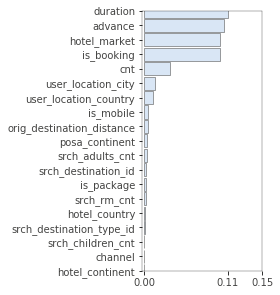

In [40]:
imp = importances(rf, df_imp, ytest)
viz = plot_importances(imp)
viz.view()

### Decision Tree (1 million samples)

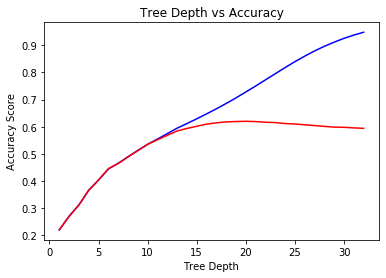

In [41]:
num_max_depths = np.arange(1,33)
accuracy_train = []
accuracy_test = []
for depth in num_max_depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(trans_xtrain, ytrain)
    
    acc_train = accuracy_score(ytrain, dt.predict(trans_xtrain))
    accuracy_train.append(acc_train)
    
    acc_test = accuracy_score(ytest, dt.predict(trans_xtest))
    accuracy_test.append(acc_test)
    
line1 = plt.plot(num_max_depths, accuracy_train, "b", label= "Train accuracy")
line2 = plt.plot(num_max_depths, accuracy_test, "r", label= "Test accuracy")

plt.title("Tree Depth vs Accuracy")
plt.ylabel("Accuracy Score")
plt.xlabel("Tree Depth")
plt.show()

## Best Model (full dataset)

In [42]:
# Reset the index
sample_x = df_X.reset_index(drop=True)
sample_y = df_y.reset_index(drop=True)

# Calling datetime and drop column
sample_x = datetime_eng(sample_x)
sample_x = drop_col(sample_x)

In [43]:
# Train test split on the data
xtrain, xtest, ytrain, ytest = train_test_split(sample_x, sample_y, test_size=.2 ,random_state=42)
xtrain.shape, xtest.shape

((3136497, 19), (784125, 19))

In [44]:
# Make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(xtrain)
trans_xtest = pipeline.transform(xtest)

In [45]:
# Training the best model according to the plots with more depths (15) (100, 16)
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_features=16,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features=16, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [46]:
# Accuracy Score
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"Out of Bag Accuracy: {rf.oob_score_}")

Training Accuracy Score: 0.6301211191976271
Testing Accuracy Score: 0.6273183484776024
Out of Bag Accuracy: 0.6259231237906493


In [47]:
# Precision scores
print(f"Training weighted-precision-score: {precision_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing weighted-precision-score: {precision_score(ytest, best_rf.predict(trans_xtest), average='weighted')}")

Training weighted-precision-score: 0.5694281345327323
Testing weighted-precision-score: 0.5701752209586058


In [48]:
# F1-scores
print(f"Training weighted-f1-Score: {round(f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted'), 2)}")
print(f"Testing weighted-f1-Score: {round(f1_score(ytest, best_rf.predict(trans_xtest), average='weighted'), 2)}")

Training weighted-f1-Score: 0.56
Testing weighted-f1-Score: 0.56


In [49]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77     76421
           1       0.99      0.99      0.99     90489
           2       0.54      0.54      0.54     86933
           3       0.70      0.39      0.50     45043
           4       0.57      0.64      0.60     70054
           5       0.52      0.50      0.51    123879
           6       0.54      0.38      0.45     76681
           7       0.57      0.53      0.55     50372
           8       0.66      0.76      0.71     66592
           9       0.53      0.55      0.54     97661

    accuracy                           0.63    784125
   macro avg       0.63      0.62      0.62    784125
weighted avg       0.63      0.63      0.62    784125



## Summary


The goal of this project was to predict which hotel cluster a user will book based on their behaviors on the website and other various information. The business impact of this goal can help Expedia provide personalized hotel recommendations to their users to improve user experience with their vacation planning, which can ultimately increase revenue for Expedia.

We downsampled the original dataset from 0-99 (37 million samples) hotel cluster IDs to only 0-9 (4 million samples) hotel cluster IDs. In addition, for a more efficient workflow, we randomly sampled 1 million samples to minimize runtime. Models that we used for this project include Random Forest, Decision Tree, Multiclass Logistic Regression, and k-nearest neighbor. For this problem, precision is the north star metric because we want to develop a model that will predict hotel clusters as precise as possible. 

After running the four different model with default hyperparameters, we found that Decision Tree and Random Forest are good baseline models to improve. After tuning for the best hyperparameters for these two models, we ran the models with 4 million rows dataset and achieved around 63% weighted average precision score for both Random Forest and Decision Tree.

In a business view, a weighted average precision around 63% in our context means that the model can correctly predict 63% each hotel cluster ID 0-9 in weighted average, is correctly predicted. Our model does a better job than randomly predicting a hotel cluster. However, productizing our model depends on how well the current Expedia's model performs. One advantage of our model is its speed in returning a result. Random Forest and Decision Tree are fast to show a predicted hotel cluster once the models are trained. For user experience perspective, a user doesn't have to wait a long time to see the outcome/predicted hotel cluster. 